In [1]:
import tensorflow as tf
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
class RoastBot(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, batch_size, conv_arr, rnn_arr, latent_dim=256):
        super(RoastBot, self).__init__()
        self.conv_layers = []
        conv_info = conv_arr[0]
        self.img_input = tf.keras.layers.Conv2D(filters=conv_info['filters'],
                                               kernel_size=conv_info['kernel'],
                                               strides=conv_info['strides'],
                                               padding='same', activation=conv_info['activation'],
                                               batch_input_shape=[batch_size,None,None,3],
                                               name='image_input')
        self.conv_layers.append(self.img_input)
        self.text_input = tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size,None],
                                                   name='seq_input')
        # initializing convolutional layers
        
        for conv_info in conv_arr[1:]:
            conv_layer = tf.keras.layers.Conv2D(filters=conv_info['filters'],
                                               kernel_size=conv_info['kernel'],
                                               strides=conv_info['strides'],
                                               padding='same', activation=conv_info['activation'])
            self.conv_layers.append(conv_layer)
        self.flatten = tf.keras.layers.Flatten()
        self.latent_space = tf.keras.layers.Dense(latent_dim, activation='relu', name='latent_space')
        # initializing recurrent layers
        self.rnn_layers = []
        for rnn_info in rnn_arr:
            rnn_layer = tf.keras.layers.GRU(rnn_info['units'],
                                       return_sequences=True, stateful=True,
                                       recurrent_initializer='glorot_uniform')
            self.rnn_layers.append(rnn_layer)
        self.vocab = tf.keras.layers.Dense(vocab_size,name='output_token')
    
    def call(self, inputs):
        img = inputs['input_1']
        #print(img)
        text = tf.convert_to_tensor(inputs['input_2'])
        x = self.img_input(img)
        x_prime = self.text_input(text)
        
        for layer in self.conv_layers:
            x = layer(x)
        x = self.flatten(x)
        #x = tf.expand_dims(x, axis=0)
        
        x = self.latent_space(x)
        x = tf.expand_dims(x, axis=1)
        #print('x_shape:',x.shape,'x_prime:',x_prime.shape)
        x = tf.concat((x,x_prime),1)
        for layer in self.rnn_layers:
            x = layer(x)
        return self.vocab(x)
        

In [3]:
# training tokenizer
roasts_total = []
with open('reddit_roasts.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    for line in text.split('NEWLINE!!!'):
        roasts = line.split('~')[1:]
        [roasts_total.append(r + ' endofseq') for r in roasts]

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=4000)
tokenizer.fit_on_texts(roasts_total)

In [4]:
tokenizer.sequences_to_texts([[0],[1],[2],[3]])

['', 'endofseq', 'you', 'the']

In [5]:
conv_arr = [
    {'filters': 3, 'kernel': 3, 'strides': 2, 'activation': 'relu'},
    {'filters': 8, 'kernel': 3, 'strides': 2, 'activation': 'relu'},
]
#del model
model = RoastBot(vocab_size=4000, embedding_dim=256,batch_size=128,conv_arr=conv_arr,rnn_arr=[])

In [21]:
augmentor = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255., rotation_range=20,
                                                           horizontal_flip=True)

In [6]:
def lookup_img(_id):
    filename = './faces/{}.png'.format(_id)
    img = cv2.resize(cv2.imread(filename), (256,256))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
def generator():
    with open('reddit_roasts.txt','r', encoding='utf-8') as f:
        text = f.read()
        for line in text.split('NEWLINE!!!'):
            #print(line)
            elements = line.split('~')
            _id = elements[0]
            for roast in elements[1:]:
                img = lookup_img(_id)
                #print(roast + ' endofseq')
                seq = tokenizer.texts_to_sequences([roast + ' endofseq'])
                seq = tf.keras.preprocessing.sequence.pad_sequences(seq, padding='post', maxlen=100)
                yield {'input_1': img, 'input_2': seq[0]}



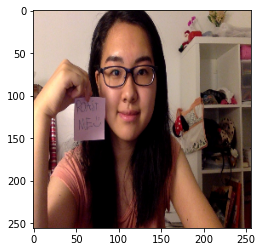

In [7]:
img = lookup_img('3by2xz')
plt.imshow(img)

In [8]:
input_dict = {}
input_dict['input_1'] = img.reshape((1,img.shape[0],img.shape[1],3)).astype(np.float32)
input_dict['input_2'] = tokenizer.texts_to_sequences([u'You look like '])
model(input_dict)

<tf.Tensor: shape=(1, 4, 4000), dtype=float32, numpy=
array([[[-7.35611725e+00, -2.15621305e+00,  1.29576647e+00, ...,
          3.54266405e-01, -4.63194752e+00,  5.57941914e-01],
        [ 2.78050709e-03, -1.38867786e-02, -1.36220995e-02, ...,
         -5.06245950e-03,  8.27384833e-03,  2.17148028e-02],
        [-1.66071728e-02, -1.07723493e-02, -3.75646004e-03, ...,
         -5.08151855e-03, -7.66397081e-03,  1.67558272e-03],
        [-6.22554962e-03,  1.08215213e-03,  1.55595560e-02, ...,
          7.89785292e-03,  1.47696435e-02, -1.74379395e-03]]],
      dtype=float32)>

In [9]:
gen = generator()
for val in [next(gen) for _ in range(1)]:
    batch_of_one = split_input_target(val)
    x,y = batch_of_one[0], batch_of_one[1]
    print('input_sequence (as text)')
    texts = x['input_2']
    texts = [[val.numpy()] for val in texts]
    seq = tokenizer.sequences_to_texts(texts)
    print(seq)
    print('output_sequence (as text)')
    y = [[val.numpy()] for val in y]
    print(tokenizer.sequences_to_texts(y))

NameError: name 'split_input_target' is not defined

In [9]:
dataset = tf.data.Dataset.from_generator(generator, output_types={'input_1':tf.float32,'input_2':tf.int32},
                                        output_shapes={'input_1':tf.TensorShape([None,None,3]),
                                                      'input_2':tf.TensorShape([None])})

In [10]:
tokenizer.texts_to_sequences(['endofseq'])

[[1]]

In [11]:
@tf.function
def split_input_target(chunk):
    input_text = chunk['input_2'][:-2]
    output_text = chunk['input_2'][1:]
    print(len(input_text), len(output_text))
    #tf.print(input_text, output_text)
    return {'input_1': chunk['input_1'], 'input_2': input_text}, output_text

dataset = dataset.map(split_input_target)

Tensor("strided_slice_2:0", shape=(), dtype=int32) Tensor("strided_slice_3:0", shape=(), dtype=int32)


In [12]:
dataset

<MapDataset shapes: ({input_1: (None, None, 3), input_2: (None,)}, (None,)), types: ({input_1: tf.float32, input_2: tf.int32}, tf.int32)>

In [13]:
BATCH_SIZE = 2
BUFFER_SIZE = 200
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset

<BatchDataset shapes: ({input_1: (None, None, None, 3), input_2: (None, None)}, (None, None)), types: ({input_1: tf.float32, input_2: tf.int32}, tf.int32)>

In [14]:
test_dataset = dataset.enumerate().filter(lambda x,y: x % 5 == 0).map(lambda x,y: y)
train_dataset = dataset.enumerate().filter(lambda x,y:x % 5 != 0).map(lambda x,y: y)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to identify source code of lambda function <function <lambda> at 0x0000022733D5A1F0>. It was defined on this line: test_dataset = dataset.enumerate().filter(lambda x,y: x % 5 == 0).map(lambda x,y: y)
, which must contain a single lambda with matching signature. To avoid ambiguity, define each lambda in a separate expression.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to identify source code of lambda function <function <lambda> at 0x0000022733D5A1F0>. It was defined on this line: test_dataset = dataset.enumerate().filter(lambda x,y: x % 5 == 0).map(lambda x,y: y)
, which must contain a single l

In [15]:
EPOCHS = 10

def logits_loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam',loss=logits_loss)

In [16]:
train_dataset

<MapDataset shapes: ({input_1: (None, None, None, 3), input_2: (None, None)}, (None, None)), types: ({input_1: tf.float32, input_2: tf.int32}, tf.int32)>

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_prefix, save_weights_only=True)

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)

In [20]:
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset,
         callbacks=[checkpoint_callback,early_stopping])

Epoch 1/10
644/644 [==============================] - 310s 481ms/step - loss: 0.8732 - val_loss: 0.8645
Epoch 2/10
644/644 [==============================] - 309s 479ms/step - loss: 0.8258 - val_loss: 0.7540
Epoch 3/10
644/644 [==============================] - 308s 478ms/step - loss: 0.7706 - val_loss: 0.7320
Epoch 4/10
644/644 [==============================] - 307s 477ms/step - loss: 0.7168 - val_loss: 0.6367
Epoch 5/10
644/644 [==============================] - 308s 478ms/step - loss: 0.6637 - val_loss: 0.6002
Epoch 6/10
644/644 [==============================] - 310s 481ms/step - loss: 0.6261 - val_loss: 0.5622
Epoch 7/10
644/644 [==============================] - 308s 478ms/step - loss: 0.5790 - val_loss: 0.5640
